## Imports and definitions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
path = "data/"
sz = 256
bs = 64
arch = resnext101_64

## Submission definition

In [4]:
def submit_predictions(learner, is_tta=True):
    if is_tta:
        log_probs,_ = learner.TTA(is_test=True)
        probs = np.exp(log_probs)
        probs = np.mean(probs, axis=0)
    else:
        log_probs = learn.predict(is_test=True)
        probs = np.exp(log_probs)
    probs = np.clip(probs, 0.0001, 0.9999)
    test_fnames = data.test_dl.dataset.fnames
    test_ids = list(map(lambda x: re.split('/|\.',x)[1], test_fnames))
    probs_flattened = probs.flatten()
    probs_formatted = np.array(list(map(lambda x: '%0.6f'%x, probs_flattened)))
    probs_formatted = np.reshape(probs_formatted, probs.shape)
    result = list(map(lambda x: [test_ids[x]] + list(probs_formatted[x]), range(len(test_ids))))
    
    result_file = "./data/results/result.csv"
    header = ','.join(['id']+data.classes)
    np.savetxt(result_file, result, delimiter=',', comments='', fmt='%s', header=header)
    !kg submit {result_file}

In [5]:
!rm -r {path}tmp

## Validation data split

In [5]:
def get_data(sz, bs, val_split=0.15):
    label_csv = f'{path}labels.csv'
    n = len(list(open(label_csv)))-1
    val_idxs = get_cv_idxs(n, val_pct=val_split)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path, 'train', label_csv, test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz < 300 else data.resize(300,'tmp')

## Model Training

In [6]:
data = get_data(sz, bs)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5, xtra_fc=[500])

### Train with precomputed layers

In [8]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 112/136 [00:02<00:00, 49.16it/s, loss=14.8]


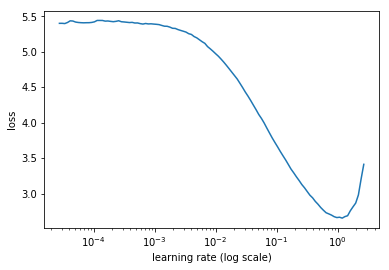

In [9]:
learn.sched.plot()

In [10]:
learn.fit(0.1, 1, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.794149   0.39529    0.898341  
    1      0.344491   0.311013   0.924383                    
    2      0.24158    0.232736   0.936817                    



[0.2327363, 0.9368169407049814]

In [19]:
submit_predictions(learn)

0.21561                                       


### Train with data augmentation

In [11]:
learn.precompute = False

In [12]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 90%|████████▉ | 122/136 [02:09<00:14,  1.06s/it, loss=1.08] 

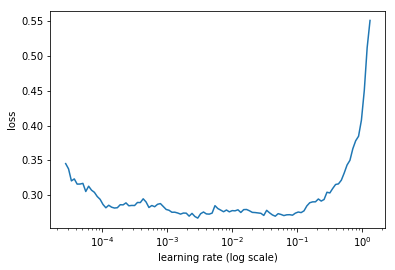

In [13]:
learn.sched.plot()

In [14]:
learn.fit(0.001, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  4%|▎         | 5/136 [00:07<03:10,  1.45s/it, loss=0.328]

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.268675   0.195118   0.936166  
    1      0.260181   0.191749   0.936166                    
    2      0.28491    0.191483   0.936817                    
    3      0.264635   0.189559   0.936817                    
    4      0.263099   0.18976    0.936817                    
    5      0.27498    0.19054    0.937468                    
    6      0.249701   0.189769   0.936166                    



[0.1897691, 0.9361658990383148]

In [15]:
learn.save('resnext_500_extra')

In [16]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.259425   0.1861     0.934864  



[0.18610032, 0.9348638157049814]

In [17]:
submit_predictions(learn)

0.20969                                       


In [18]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 90%|████████▉ | 122/136 [02:09<00:14,  1.06s/it, loss=1.05] 

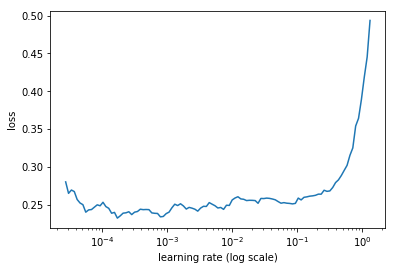

In [19]:
learn.sched.plot()

In [20]:
learn.fit(0.0001, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  2%|▏         | 3/136 [00:03<02:54,  1.31s/it, loss=0.311] 


Exception in thread Thread-21:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.233581   0.185537   0.935515  
    1      0.232597   0.18554    0.937468                    
    2      0.239007   0.18627    0.935515                    



[0.18626954, 0.9355148573716482]

In [21]:
learn.save('resnext_500_intermediate')

## Unfreeze and learn

In [22]:
learn.unfreeze()

In [23]:
learn.fit([1e-5, 1e-4, 1e-2], 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/136 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/generic/THCStorage.cu:58

## Learn with larger dataset

In [20]:
data299 = get_data(299, bs, val_split=0.01)
learn.set_data(data299)
learn.freeze()

In [24]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 134/159 [03:21<00:37,  1.51s/it, loss=0.787]

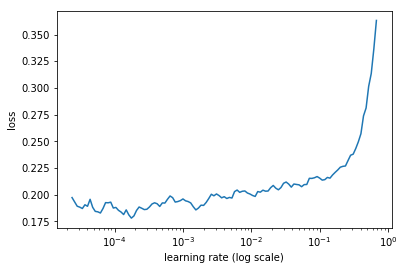

In [22]:
learn.sched.plot()

In [ ]:
learn.fit(0.0001, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.202236   0.114659   0.958059  
    1      0.199504   0.116147   0.958059                    



[0.11614703, 0.9580592215061188]

In [29]:
learn.eval(data)

AttributeError: 'ConvLearner' object has no attribute 'eval'

In [30]:
submit_predictions(learn)

KeyboardInterrupt: 